In [ ]:
!pip install byaldi pdf2image qwen-vl-utils transformers

In [ ]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import requests
from pdf2image import convert_from_path

# URLs of the PDFs to download
pdfs = {
    "Window": "https://www.westoxon.gov.uk/media/ksqgvl4b/10-design-guide-windows-and-doors.pdf",
    "Roofs": "https://www.westoxon.gov.uk/media/d3ohnpd1/9-design-guide-roofs-and-roofing-materials.pdf",
    "Extensions": "https://www.westoxon.gov.uk/media/pekfogvr/14-design-guide-extensions-and-alterations.pdf",
    "Greener": "https://www.westoxon.gov.uk/media/thplpsay/16-design-guide-greener-traditional-buildings.pdf",
    "Sustainable": "https://www.westoxon.gov.uk/media/nk5bvv0v/12-design-guide-sustainable-building-design.pdf"
}

# Directory for saving PDFs
output_dir = "/content/dataset"
!mkdir -p {output_dir}

# Download PDFs
for name, url in pdfs.items():
    response = requests.get(url)
    pdf_path = f"{output_dir}/{name}.pdf"

    with open(pdf_path, "wb") as f:
        f.write(response.content)

print("PDFs downloaded successfully!")

PDFs downloaded successfully!


In [ ]:
def convert_pdfs_to_images(folder):
    from pathlib import Path
    pdf_files = list(Path(folder).glob("*.pdf"))
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        images = convert_from_path(str(pdf_file), dpi=100)
        all_images[doc_id] = images
        print(f"Converted {pdf_file.name} to {len(images)} images.")

    return all_images

# Convert PDFs to images
all_images = convert_pdfs_to_images(output_dir)
print("PDFs converted to images successfully!")

Converted Roofs.pdf to 7 images.
Converted Window.pdf to 11 images.
Converted Greener.pdf to 17 images.
Converted Extensions.pdf to 11 images.
Converted Sustainable.pdf to 13 images.
PDFs converted to images successfully!


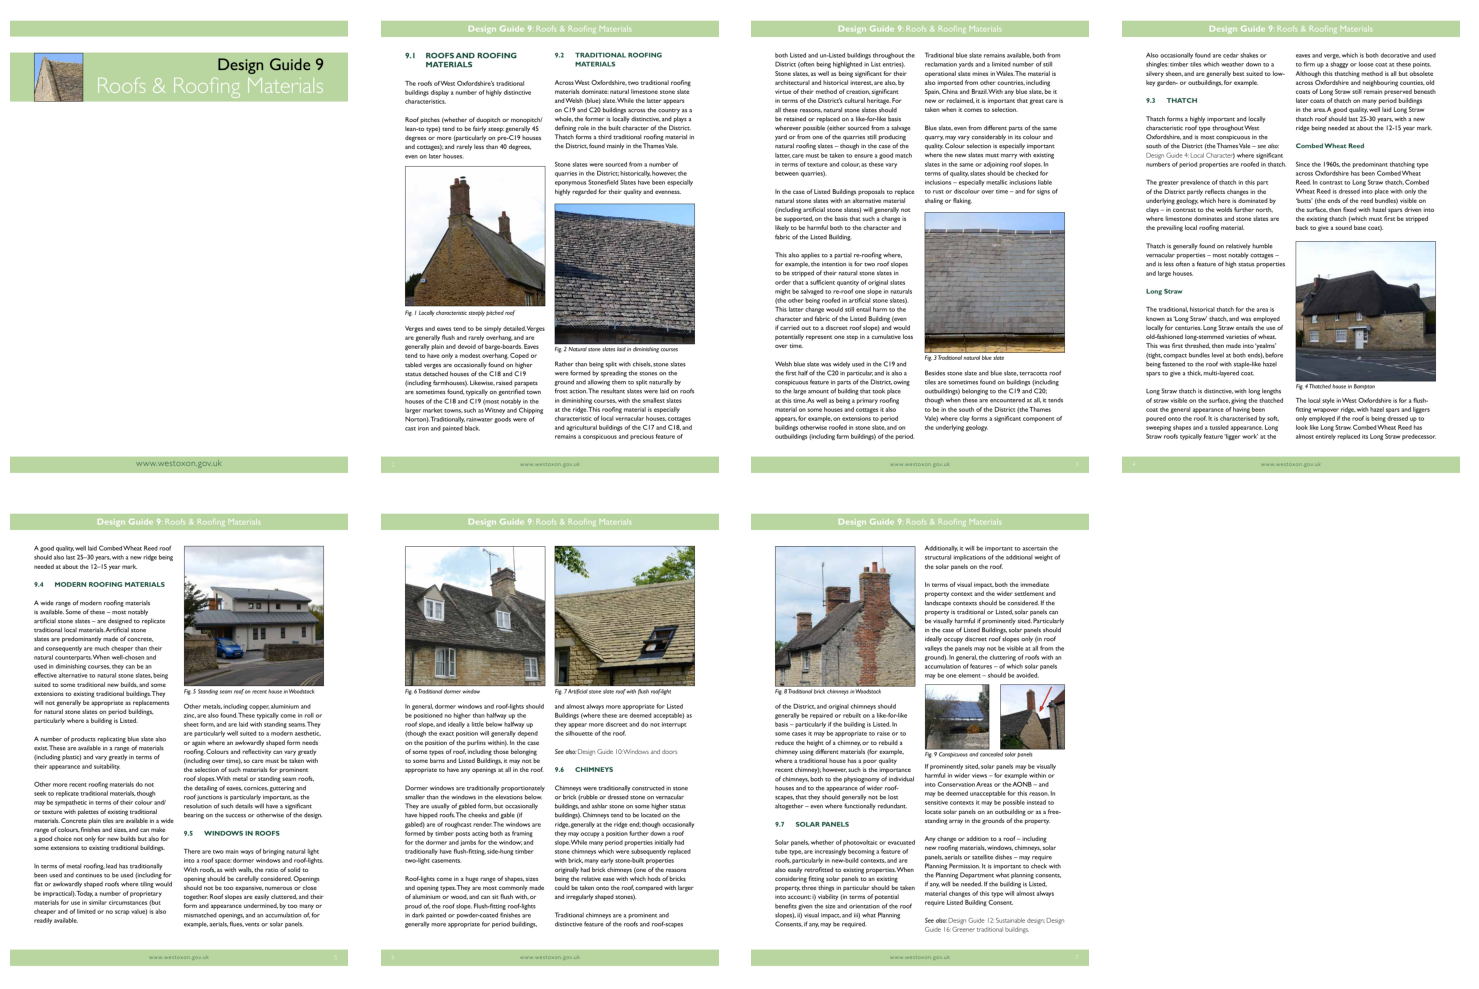

In [ ]:
import matplotlib.pyplot as plt

# Access images from a specific document (e.g., "Roofs.pdf")
doc_index = 0  # Change this index to visualize other PDFs
images = all_images[doc_index]

# Determine grid size dynamically
num_images = len(images)
cols = 4  # Number of columns
rows = (num_images + cols - 1) // cols  # Calculate rows dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes for easy iteration
axes = axes.flat if rows > 1 else [axes]

# Plot each image
for i, ax in enumerate(axes):
    if i < num_images:
        ax.imshow(images[i])
        ax.axis('off')
    else:
        ax.axis('off')  # Hide unused axes

plt.tight_layout()
plt.show()

In [ ]:
from byaldi import RAGMultiModalModel

colpali_model = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
colpali_model.index(
    input_path="dataset/",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

overwrite is on. Deleting existing index image_index to build a new one.
Indexing file: dataset/Roofs.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Index exported to .byaldi/image_index
Indexing file: dataset/Window.pdf
Added page 1 of document 1 to index.
Added page 2 of document 1 to index.
Added page 3 of document 1 to index.
Added page 4 of document 1 to index.
Added page 5 of document 1 to index.
Added page 6 of document 1 to index.
Added page 7 of document 1 to index.
Added page 8 of document 1 to index.
Added page 9 of document 1 to index.
Added page 10 of document 1 to index.
Added page 11 of document 1 to index.
Index exported to .byaldi/image_index
Indexing file: dataset/Greener.pdf
Added page 1 of document 2 to index.
Added page 2 of document 2 to index.
Added p

{0: 'dataset/Roofs.pdf',
 1: 'dataset/Window.pdf',
 2: 'dataset/Greener.pdf',
 3: 'dataset/Extensions.pdf',
 4: 'dataset/Sustainable.pdf'}

In [ ]:
query = "What role does passive design play in creating sustainable houses?"

results = colpali_model.search(query, k=2)
results

[{'doc_id': 4, 'page_num': 8, 'score': 14.625, 'metadata': {}, 'base64': None},
 {'doc_id': 4, 'page_num': 3, 'score': 14.5, 'metadata': {}, 'base64': None}]

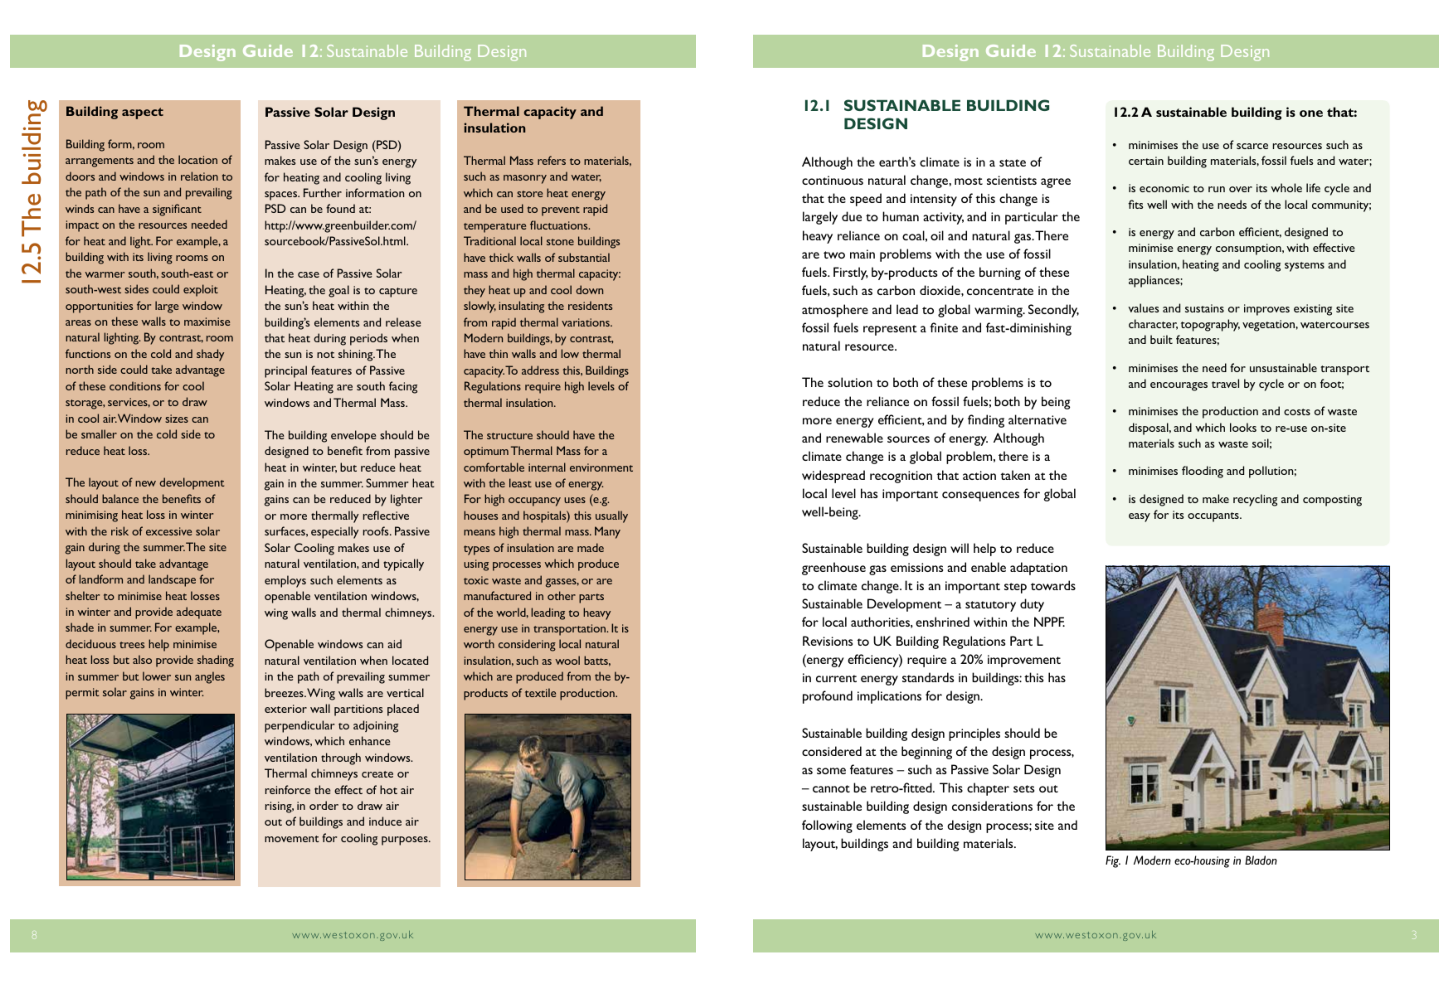

In [ ]:
import matplotlib.pyplot as plt

def get_result_images(results, all_images):
    grouped_images = []

    for result in results:
        doc_id = result['doc_id']
        page_num = result['page_num']
        grouped_images.append(all_images[doc_id][page_num - 1])
    return grouped_images

# Example usage
result_images = get_result_images(results, all_images)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Use result_images instead of grouped_images
for i, ax in enumerate(axes.flat):
    img = result_images[i]  # Use result_images
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info
import torch

vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
)
vl_model.cuda().eval()

In [ ]:
min_pixels = 256*256
max_pixels = 1024*1024
vl_model_processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

In [ ]:
chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": result_images[0],  # First image
            },
            {
                "type": "image",
                "image": result_images[1],  # Second image
            },
            {
                "type": "text",
                "text": query  # The text query for the model
            },
        ],
    }
]

# Apply the chat template to the model processor
text = vl_model_processor.apply_chat_template(
    chat_template, tokenize=False, add_generation_prompt=True
)

In [ ]:
image_inputs, _ = process_vision_info(chat_template)
inputs = vl_model_processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cpu")

In [ ]:
# Generate the output tokens
generated_ids = vl_model.generate(**inputs, max_new_tokens=10)

# Trim the generated IDs to remove the input IDs part
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs['input_ids'], generated_ids)
]

# Decode the generated IDs to text
output_text = vl_model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

# Print the output text
print(output_text[0])

In [ ]:
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration

model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16, device_map="auto")

model.cuda().eval()

In [ ]:
min_pixels = 256*256
max_pixels = 1024*1024
vl_model_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

In [ ]:
chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": result_images[0],  # First image
            },
            {
                "type": "image",
                "image": result_images[1],  # Second image
            },
            {
                "type": "text",
                "text": query  # The text query for the model
            },
        ],
    }
]

# Apply the chat template to the model processor
text = model_processor.apply_chat_template(
    chat_template, tokenize=False, add_generation_prompt=True
)

In [ ]:
image_inputs, _ = processor.image_processor(chat_template, return_tensors="pt")
inputs = model_processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)

In [ ]:
# Generate the output tokens
generated_ids = model.generate(**inputs, max_new_tokens=10)

# Trim the generated IDs to remove the input IDs part
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs['input_ids'], generated_ids)
]

# Decode the generated IDs to text
output_text = model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

# Print the output text
print(output_text[0])